In [1]:
!pip install -Uqq ipdb
!pip install torchmetrics
!pip install torchsummary

In [2]:
import ipdb
import time

import numpy as np
import pandas as pd
import os
from os.path import join
import glob
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


from PIL import Image
import random
from tqdm import tqdm


from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

import torch
from torch import nn

from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

from torchmetrics import Accuracy

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

torch.manual_seed(123)
from tqdm.notebook import tqdm


# Ignore all warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [3]:
## define parameters
train_on_gpu = torch.cuda.is_available() ## it will return True or False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [4]:
try:
    dataset_path = '/kaggle/input/places2-mit-dataset/train_256_places365standard/data_256/'
    
    ## Get the total No of Folders
    main_folders = os.listdir( dataset_path )
    print(len(main_folders))
    
except Exception as e:
    print(e)
    print('Running inside the Except with different path')
    dataset_path = '/kaggle/input/train_256_places365standard/data_256/'

    ## Get the total No of Folders
    main_folders = os.listdir( dataset_path )
    print(len(main_folders))

24


## Load the data file

In [5]:
df = pd.read_csv( '/kaggle/input/places-data/places_data.csv' ).drop( 'Unnamed: 0', axis = 1 )
print(df.shape)
df.head(5)

(1803460, 2)


,file_name,class
0,f^forest^broadleaf#00002273.jpg,f^forest^broadleaf
1,a^auditorium#00004236.jpg,a^auditorium
2,i^ice_cream_parlor#00000914.jpg,i^ice_cream_parlor
3,s^swimming_hole#00003206.jpg,s^swimming_hole
4,d^desert^sand#00003949.jpg,d^desert^sand


In [6]:
# Shuffle the rows of the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,file_name,class
0,p^pier#00004978.jpg,p^pier
1,a^amphitheater#00004406.jpg,a^amphitheater
2,b^beach#00004028.jpg,b^beach
3,s^shopfront#00004798.jpg,s^shopfront
4,d^dining_room#00001582.jpg,d^dining_room


## Displaying some sample Images from the dataset

In [7]:
image_paths = []
for i in range(10):
    image_name = df.iloc[i]['file_name'].split('#')[1]
    sub_path   = '/'.join(df.iloc[i]['file_name'].split('#')[0].split('^'))
    image_path = join( dataset_path, sub_path, image_name )
    image_paths.append( image_path )

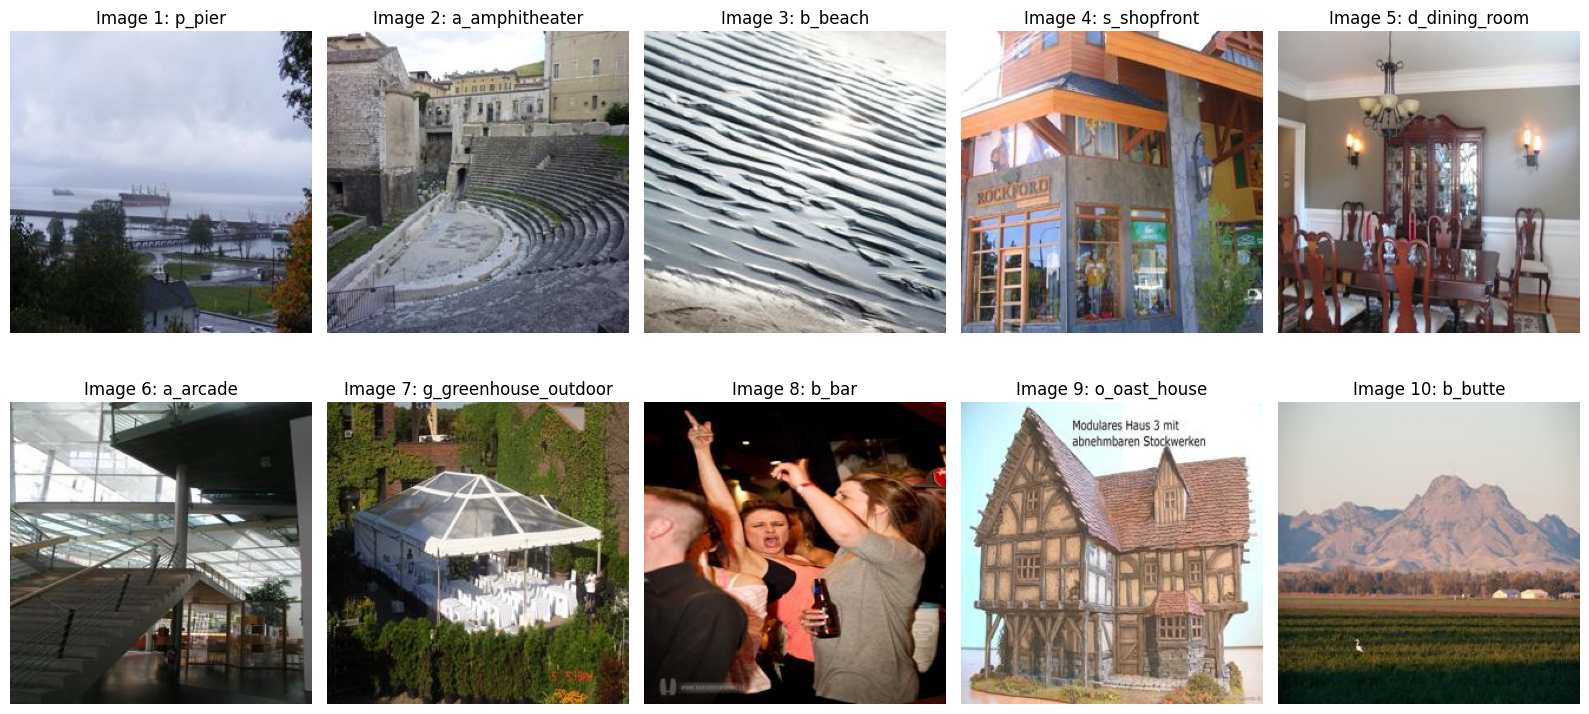

In [8]:
# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop over the image paths and display each image in a subplot
for i, img_path in enumerate(image_paths):
    image_name = '_'.join(img_path.split('data_256')[1].split('/')[1:-1])
    img = plt.imread(img_path)
    
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f'Image {i+1}: {image_name}')  # Set title (optional)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Class Distribution
#### We have 365 classes in the dataset. Except the following 26 classes, all the other classes have 5000 images

In [9]:
df['class'].value_counts().index[-26:]

Index(['p^pet_shop', 'g^greenhouse^outdoor', 'g^gymnasium^indoor',
       'o^operating_room', 'v^veterinarians_office', 'g^general_store^indoor',
       'b^bullring', 'e^elevator^door', 'c^crevasse', 'b^bazaar^indoor',
       'v^volleyball_court^outdoor', 'g^galley', 'm^market^indoor',
       'e^escalator^indoor', 'a^assembly_line', 'i^ice_skating_rink^indoor',
       's^sauna', 'c^clean_room', 'f^fabric_store', 'd^drugstore',
       'c^computer_room', 'b^bank_vault', 'b^biology_laboratory',
       'c^chemistry_lab', 'j^jacuzzi^indoor', 'd^dressing_room'],
      dtype='object', name='class')

In [10]:
print( len(df['class'].value_counts().values[-26:]) )
df['class'].value_counts().values[-26:]

26


array([4988, 4939, 4906, 4826, 4809, 4735, 4681, 4461, 4457, 4421, 4366,
       4330, 4266, 4254, 4168, 4104, 4020, 3871, 3858, 3781, 3619, 3500,
       3469, 3447, 3116, 3068])

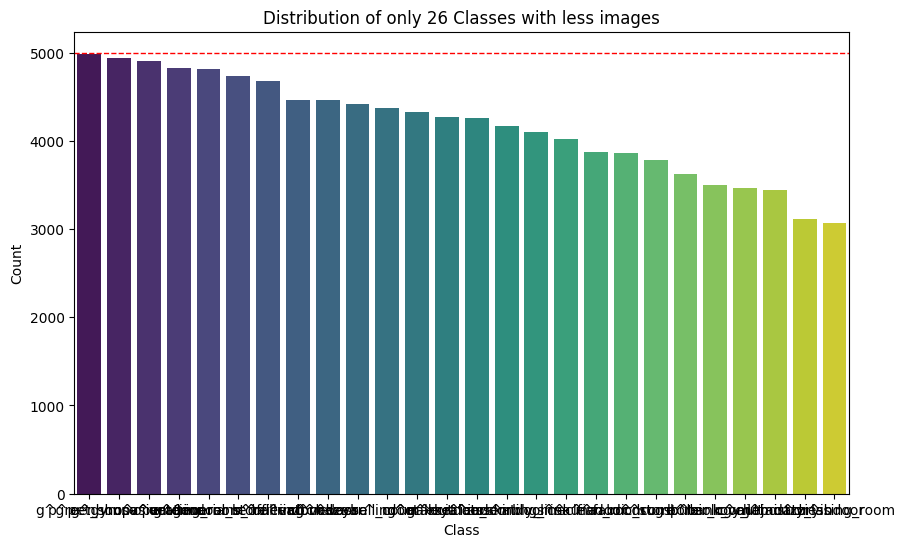

In [11]:
# Plot the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.barplot( x = df['class'].value_counts().index[-26:], 
             y = df['class'].value_counts().values[-26:], palette='viridis')

# Add a horizontal line at y=5000
plt.axhline( y = 5000, color = 'red', linestyle = '--', linewidth = 1 )

plt.title('Distribution of only 26 Classes with less images')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Dropping (26) classes with < 5000 images

In [12]:
classes_to_remove = df['class'].value_counts().index[-26:].tolist()
print(len(classes_to_remove))

26


In [13]:
df_ = df[~df['class'].isin(classes_to_remove)]
print(df_.shape)
df_.head(5)

(1695000, 2)


,file_name,class
0,p^pier#00004978.jpg,p^pier
1,a^amphitheater#00004406.jpg,a^amphitheater
2,b^beach#00004028.jpg,b^beach
3,s^shopfront#00004798.jpg,s^shopfront
4,d^dining_room#00001582.jpg,d^dining_room


## Assign labels to classes using LabelEncoder

In [14]:
## 339 total classes

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'class' column
df['label']  = label_encoder.fit_transform(df['class'])

# Display the updated dataframe
print(df.shape)
df.head(5)

(1803460, 3)


,file_name,class,label
0,p^pier#00004978.jpg,p^pier,266
1,a^amphitheater#00004406.jpg,a^amphitheater,5
2,b^beach#00004028.jpg,b^beach,48
3,s^shopfront#00004798.jpg,s^shopfront,301
4,d^dining_room#00001582.jpg,d^dining_room,121


In [15]:
## total number of classes left
num_classes = len(df['label'].value_counts())
num_classes

365

## Dividing data into Train, Test and validation
- Train:      60 %
- Test:        20 %
- Valid: 20 %

In [16]:
# First, split the data into 60% train and 40% temp (test + validation)
df_train, temp_df = train_test_split( df, test_size = 0.4, stratify = df['label'], random_state = 42 )

# Then, split the temp (40%) into 20% test and 20% validation
df_test, df_valid = train_test_split( temp_df, test_size = 0.5, stratify = temp_df['label'], random_state = 42 )

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

# Check the sizes of the splits
print(f"Train set size: {len(df_train)} -- {(df_train.shape[0]/df_.shape[0])*100} %")
print(f"Test set size:  {len(df_test)}  -- {(df_test.shape[0]/df_.shape[0])*100} %")
print(f"Valid set size: {len(df_valid)}  -- {(df_valid.shape[0]/df_.shape[0])*100} %")

Train set size: 1082076 -- 63.83929203539823 %
Test set size:  360692  -- 21.27976401179941 %
Valid set size: 360692  -- 21.27976401179941 %


## Create Data set

In [17]:
## Transformations
im_size = 128

train_transforms = T.Compose( [ T.Resize( im_size ), 
                                T.ToTensor(), ] )

val_transforms   = T.Compose( [ T.Resize( im_size ), 
                                T.ToTensor(), ] )

In [18]:
class Dataset_class(Dataset):
    
    def __init__( self, root_path, df, transforms = None ):
        super( Dataset, self ).__init__()
        
        self.df         = df
        self.root_path  = root_path
        self.transforms = transforms

    def __getitem__( self, index ):
        try:            
            image_name = self.df.iloc[index]['file_name'].split('#')[1]
            sub_path   = '/'.join(self.df.iloc[index]['file_name'].split('#')[0].split('^'))
            image_path = join( self.root_path, sub_path, image_name ) 
            
            # Check if the file exists
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"File '{image_path}' does not exist.")
                

            inp = Image.open( image_path )
            gt  = torch.tensor(  self.df.iloc[index]['label'] , dtype = torch.long )

            if self.transforms is not None:
                inp = self.transforms( inp )

            return inp, gt
        
        except Exception as e:
            print(f"Error loading index {index}: {e}")
            raise

    def __len__(self):
        return len(self.df)


In [19]:
### Testing dataset class
train_set = Dataset_class( dataset_path, df_train, train_transforms )

transformed_images = []
for i in range(1):
    
    inp, label = train_set.__getitem__(i)
    print(f'Input shape: {inp.shape}')
    print(f'Label:       {label}')

    class_ = df_train[ df_train['label'] == int(label) ]['class'].iloc[0].replace('^', '_')
    print(f'Class:        {class_}\n')
    
    transformed_images.append( [ inp, class_ ] )

Input shape: torch.Size([3, 128, 128])
Label:       86
Class:        c_cemetery



In [20]:
train_set = Dataset_class( dataset_path, df_train, train_transforms )
valid_set = Dataset_class( dataset_path, df_valid, val_transforms )
test_set  = Dataset_class( dataset_path, df_test,  val_transforms )

print(f'Length of train set: {train_set.__len__()}')
print(f'Length of valid set: {valid_set.__len__()}')
print(f'Length of test  set: {test_set.__len__()}')

Length of train set: 1082076
Length of valid set: 360692
Length of test  set: 360692


In [21]:
## Set Parameters

# Device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )


# Transformer parameters
patch_size  = 16
in_channels = 3
dim_emb     = 192
num_heads   = 3
num_blocks  = 2
dropout     = 0.1

# Training parameter
epochs      = 10 # 50
lr          = 10e-4
batch_size  = 1000 # 100
num_workers = 4

In [22]:
## Create dataloaders 
train_loader = DataLoader( dataset = train_set, num_workers = num_workers, batch_size = batch_size, shuffle = True )
valid_loader = DataLoader( dataset = valid_set, num_workers = num_workers, batch_size = batch_size, shuffle = True )
test_loader  = DataLoader( dataset = test_set,  num_workers = num_workers, batch_size = batch_size, shuffle = True )

print(f'Length of train loader: {len(train_loader)}')
print(f'Length of valid loader: {len(valid_loader)}')
print(f'Length of test  loader: {len(test_loader)}')


Length of train loader: 1083
Length of valid loader: 361
Length of test  loader: 361


## Model with pretrained weights

In [23]:
import torchvision
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

In [24]:
num_classes

365

In [25]:
# Define the model architecture (MobileNetV2)
net = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')  # Load pre-trained weights

# Adjust the final classification layer
# Get the number of input features for the last layer
num_ftrs = net.classifier[1].in_features  

net.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 640),  
    nn.GELU(),  
    nn.Linear(640, num_classes)  
)

# Move the model to the appropriate device (CPU or GPU)
net.to(device)
print()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 150MB/s]


In [26]:
from torchsummary import summary

# Print model summary
# Input shape (channels, height, width)
summary( net, (3, 128, 128) )  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

In [27]:
dict(net.named_children()).keys()

dict_keys(['features', 'classifier'])

In [28]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "classifier" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters

Unfreezing layer: classifier, Parameter shape: torch.Size([640, 1280])
Unfreezing layer: classifier, Parameter shape: torch.Size([640])
Unfreezing layer: classifier, Parameter shape: torch.Size([365, 640])
Unfreezing layer: classifier, Parameter shape: torch.Size([365])


In [29]:
def validate_updated( net, dl, loss_func ):
    
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    
    net.eval() # Set the network in evaluation mode
    
    with torch.no_grad(): # Disable gradient computation during validation
        
        for i, data in enumerate( tqdm(dl) ):
            inp, gt = data
            # gt = gt.squeeze()
            
            inp = inp.to(device)  # Move batch to GPU
            gt = gt.to(device)    # Move batch to GPU
            
            # Forward pass
            out = net(inp)
            
            # Compute loss
            loss = loss_func(out, gt)
            
            # Accumulate total loss
            total_loss += loss.item() * inp.size(0)  
            
            # Accumulate total samples
            total_samples += inp.size(0)  
            
            # Compute Accuracy
            # Get the index of the max logit
            _, predicted = torch.max(out, 1)  
            
            # Count correct predictions
            correct_predictions += (predicted == gt).sum().item()  
            
            
    # Compute average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Set the network back to training mode
    net.train()  
    
    return avg_loss, accuracy

In [30]:
# define loss
loss_func = nn.CrossEntropyLoss() 

# define optimizer -- lr = 0.0001
optimizer = torch.optim.Adam( params = net.parameters(), lr = 0.0001 ) 


n_iter = 0 
best_val_score = None 
decrease = 0

total_loss_train = 0
total_samples_train = 0
correct_predictions_train = 0

train_loss = []
valid_loss = []

train_accuracy = []
valid_accuracy = []

fit_time = time.time()
for cur_epoch in range( 20 ): 
    since  = time.time()
    
    for i, data in enumerate( tqdm(train_loader) ):
        inp, gt = data    
        # gt  = gt.squeeze()
        
        inp = inp.to(device)      # move batch to gpu
        gt  = gt.to(device)       # move batch to gpu
        
        optimizer.zero_grad()     # reset gradients
        
        out = net(inp)            # compute output
        
        loss = loss_func(out, gt) # compute loss
        loss.backward()           # compute backward pass
        
        optimizer.step()          # update weights
        n_iter = n_iter + 1
        
        # Accumulate total loss
        total_loss_train += loss.item() * inp.size(0)  

        # Accumulate total samples
        total_samples_train += inp.size(0)
        
        # Compute Accuracy
        _, predicted = torch.max(out, 1)  # Get the index of the max logit
        correct_predictions_train += (predicted == gt).sum().item()  # Count correct predictions
        
        
    # Compute average loss and accuracy
    avg_loss_train     = total_loss_train / total_samples_train
    avg_accuracy_train = correct_predictions_train / total_samples_train
    
    # append values for train 
    train_loss.append(     avg_loss_train )
    train_accuracy.append( avg_accuracy_train )
    
    cur_val_score, val_accuracy = validate_updated( net, valid_loader, loss_func )       # at the end, validate model
    
    # append values for validation 
    valid_loss.append(     cur_val_score )
    valid_accuracy.append( val_accuracy )
    
    print(f'Epoch: {cur_epoch}, valid loss = {round(cur_val_score,3)}, valid accuracy = {round(val_accuracy,3)}')
    print("Time/epoch: {:.2f}m       ".format( ( time.time() - since ) / 60 ))
    
    #  check if it is the best model so far
    if best_val_score is None or cur_val_score < best_val_score:
        best_val_score = cur_val_score
        print('SAVING MODEL .....................')
        
        data = {
          'net'   : net.state_dict(),
          'opt'   : optimizer.state_dict(),
          'epoch' : cur_epoch
        }
        
        torch.save( data, '_best.pth')
        
    else:
        decrease += 1
        print(f"LOSS DOESN'T DECREASE {decrease} TIME")
#         if decrease == 20:
#             print(f"STOP TRAINING")
#             break

    # save the last model
    data = {
        'net'   : net.state_dict(),
        'opt'   : optimizer.state_dict(),
        'epoch' : cur_epoch
    }
    torch.save( data, '_last.pth' )
    
print('Total time: {:.2f} m' .format( ( time.time() - fit_time ) / 60 ) )

history = { 'train_loss'       : train_loss, 
            'valid_loss'       : valid_loss,

            'train_accuracy'   : train_accuracy, 
            'valid_accuracy'   : valid_accuracy}

  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 0, valid loss = 3.03, valid accuracy = 0.297
Time/epoch: 49.53m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 1, valid loss = 2.904, valid accuracy = 0.319
Time/epoch: 36.63m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 2, valid loss = 2.85, valid accuracy = 0.328
Time/epoch: 31.93m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 3, valid loss = 2.819, valid accuracy = 0.335
Time/epoch: 31.35m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 4, valid loss = 2.797, valid accuracy = 0.338
Time/epoch: 30.87m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 5, valid loss = 2.78, valid accuracy = 0.341
Time/epoch: 30.42m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 6, valid loss = 2.761, valid accuracy = 0.345
Time/epoch: 31.89m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 7, valid loss = 2.753, valid accuracy = 0.345
Time/epoch: 30.85m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 8, valid loss = 2.749, valid accuracy = 0.346
Time/epoch: 35.35m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 9, valid loss = 2.733, valid accuracy = 0.349
Time/epoch: 31.10m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 10, valid loss = 2.726, valid accuracy = 0.35
Time/epoch: 29.48m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 11, valid loss = 2.717, valid accuracy = 0.351
Time/epoch: 29.85m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 12, valid loss = 2.711, valid accuracy = 0.353
Time/epoch: 29.62m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 13, valid loss = 2.706, valid accuracy = 0.353
Time/epoch: 29.33m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 14, valid loss = 2.705, valid accuracy = 0.353
Time/epoch: 31.43m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 15, valid loss = 2.698, valid accuracy = 0.354
Time/epoch: 29.73m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 16, valid loss = 2.692, valid accuracy = 0.355
Time/epoch: 30.03m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 17, valid loss = 2.685, valid accuracy = 0.356
Time/epoch: 30.26m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 18, valid loss = 2.683, valid accuracy = 0.357
Time/epoch: 29.78m       
SAVING MODEL .....................


  0%|          | 0/1083 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

Epoch: 19, valid loss = 2.682, valid accuracy = 0.357
Time/epoch: 28.90m       
SAVING MODEL .....................
Total time: 638.37 m


## Saving model results dictionary

In [31]:
import json 

# Convert and write JSON object to file
with open("mobilenet_CNN_history.json", "w") as outfile: 
    json.dump(history, outfile)

### Plotting Results

In [32]:
def plot_function( desc, m1, m2, stop = 5 ):
    
    plt.plot( m1, label = 'train' )
    plt.plot( m2, label = 'valid' )
    
    # Plotting a vertical line on the stopping point
#     plt.axvline(x=stop, color='r', linestyle='--', linewidth=1, label='Stop Training')
    
    plt.title(desc)
    plt.ylabel(desc)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

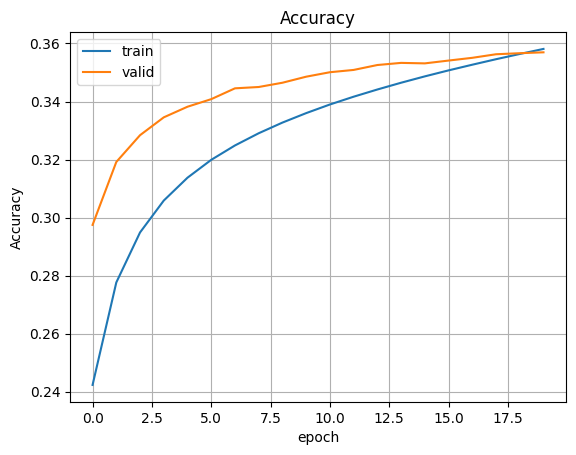

In [33]:
plot_function( 'Accuracy', history['train_accuracy'], 
                           history['valid_accuracy']  )

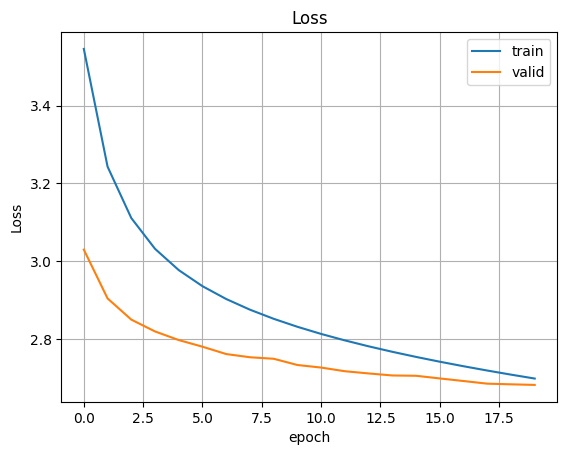

In [34]:
plot_function( 'Loss', history['train_loss'], 
                       history['valid_loss']  )

## Evaluating the model on test set

In [35]:
#  load best network
state = torch.load( '_best.pth' )
net.load_state_dict( state['net'] )

<All keys matched successfully>

In [36]:
def evaluate_function_test(net, dl, loss_func):
    
    all_pred = []
    all_gt   = []
    
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    net.eval() # Set the network in evaluation mode
    
    with torch.no_grad(): # Disable gradient computation during validation
        
        for i, data in enumerate( tqdm(dl) ):
            inp, gt = data
            gt = gt.squeeze()
            
            inp = inp.to(device)  # Move batch to GPU
            gt  = gt.to(device)    # Move batch to GPU
            
            # Forward pass
            out = net(inp)
            
            # Compute loss
            loss = loss_func(out, gt)
            total_loss += loss.item() * inp.size(0)  # Accumulate total loss
            
            # Compute accuracy
            _, pred = torch.max(out, 1)  # Get the index of the max logit
            correct_predictions += (pred == gt).sum().item()  # Count correct predictions
            total_samples += inp.size(0)  # Accumulate total samples
            
            all_pred.append( pred.tolist() )
            all_gt.append(   gt.tolist() )    
            
            
    # Compute average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    net.train()  # Set the network back to training mode
    
    return avg_loss, accuracy, all_pred, all_gt

In [37]:
loss, acc, out, gt = evaluate_function_test( net, test_loader, loss_func )
print(f'loss = {loss}  accuracy = {acc}')

  0%|          | 0/361 [00:00<?, ?it/s]

loss = 2.6759450888822247  accuracy = 0.3570969137103124


In [38]:
pred_all = torch.tensor([ p for pred in out for p in pred ])
gt_all   = torch.tensor([ p for pred in gt for p in pred ])

print(f'Length of pred: {len(pred_all)}') 
print(f'Length of   gt: {len(gt_all)}')   

Length of pred: 360692
Length of   gt: 360692


## Classification Report

In [39]:
# Compute classification report
report = classification_report( gt_all, pred_all, labels = np.arange(365) )
lines = report.split('\n')

In [40]:
lines[:10]

['              precision    recall  f1-score   support',
 '',
 '           0       0.51      0.59      0.55      1000',
 '           1       0.53      0.62      0.57      1000',
 '           2       0.28      0.32      0.30      1000',
 '           3       0.24      0.15      0.18      1000',
 '           4       0.33      0.34      0.33      1000',
 '           5       0.52      0.42      0.46      1000',
 '           6       0.47      0.52      0.50      1000',
 '           7       0.24      0.26      0.25      1000']

In [41]:
class_results = {}
for line in lines[2:-5]:  # skip header and footer lines
    line_data = line.split()
    if len(line_data) > 0:
        
        class_id  = int(line_data[0])
        precision = float(line_data[1])
        recall    = float(line_data[2])
        f1_score  = float(line_data[3])
        support   = float(line_data[4])
        
        class_results[class_id] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
            }

## Sorting the classification score matrix on the basis of F-1 score

In [42]:
# Example: Print classes with highest and lowest F1-score
best_classes  = sorted( class_results.items(), key = lambda x: x[1]['f1-score'], reverse=True)[:10]
worst_classes = sorted( class_results.items(), key = lambda x: x[1]['f1-score'])[:10] # 56

print("\nClasses with best results (highest F1-score):")
for class_id, metrics in best_classes:
    print(f"Class {class_id}: F1-score = {metrics['f1-score']:.4f}")

print("\nClasses with worst results (lowest F1-score):")
for class_id, metrics in worst_classes:
    print(f"Class {class_id}: F1-score = {metrics['f1-score']:.4f}")


Classes with best results (highest F1-score):
Class 82: F1-score = 0.8100
Class 34: F1-score = 0.7400
Class 15: F1-score = 0.7300
Class 98: F1-score = 0.7100
Class 65: F1-score = 0.7000
Class 71: F1-score = 0.6800
Class 277: F1-score = 0.6700
Class 18: F1-score = 0.6600
Class 44: F1-score = 0.6600
Class 267: F1-score = 0.6600

Classes with worst results (lowest F1-score):
Class 288: F1-score = 0.0100
Class 75: F1-score = 0.0400
Class 284: F1-score = 0.0400
Class 232: F1-score = 0.0600
Class 271: F1-score = 0.0600
Class 67: F1-score = 0.0700
Class 97: F1-score = 0.0800
Class 243: F1-score = 0.0800
Class 252: F1-score = 0.0800
Class 297: F1-score = 0.0800


## Confusion Matrix of Classes with best F-1 score

In [43]:
def display_confusion_matrix(ground_truths, predicted_labels, class_labels=None):
    # Compute confusion matrix
    cm = confusion_matrix(ground_truths, predicted_labels, labels=class_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [44]:
best_classes_predictions = [class_id for class_id, metrics in best_classes][:20]

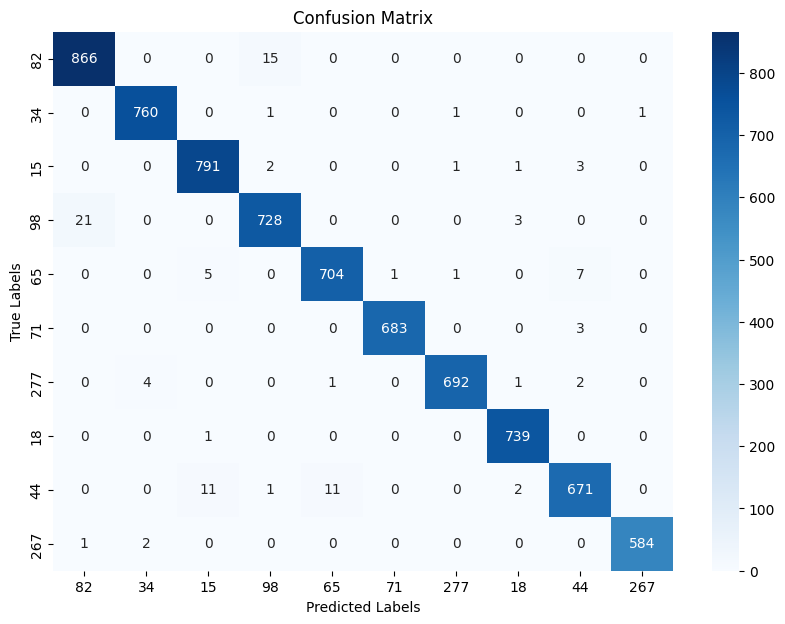

In [45]:
display_confusion_matrix(gt_all, pred_all, best_classes_predictions)

## Confusion Matrix of Classes with worst F-1 score

In [46]:
worst_classes_predictions = [class_id for class_id, metrics in worst_classes][:20]

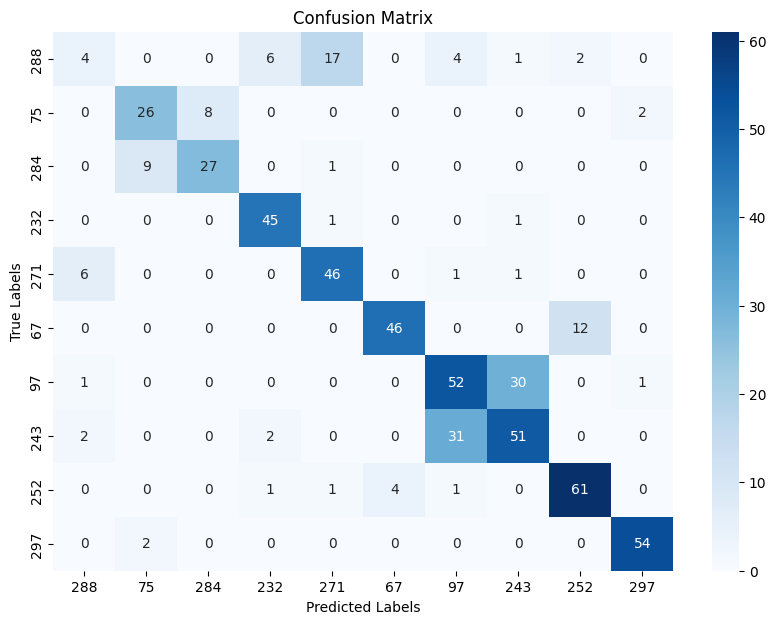

In [47]:
display_confusion_matrix(gt_all, pred_all, worst_classes_predictions)